In [1]:
import jax

jax.config.update("jax_enable_x64", True)

import astropy.units as u
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from astropy.coordinates import SkyCoord
from astropy.time import Time
from astroquery.jplhorizons import Horizons

from jorbit import Observations, Particle

In [2]:
nights = [Time("2025-01-01 07:00"), Time("2025-01-02 07:00"), Time("2025-01-05 07:00")]

times = []
for n in nights:
    times.extend([n + i * 1 * u.hour for i in range(3)])
times = Time(times)


obj = Horizons(id="274301", location="695@399", epochs=times.utc.jd)
pts = obj.ephemerides(extra_precision=True, quantities="1")

coords = SkyCoord(pts["RA"], pts["DEC"], unit=(u.deg, u.deg))
times = Time(pts["datetime_jd"], format="jd", scale="utc")

[Text(0.5, 0, 'RA'), Text(0, 0.5, 'DEC')]

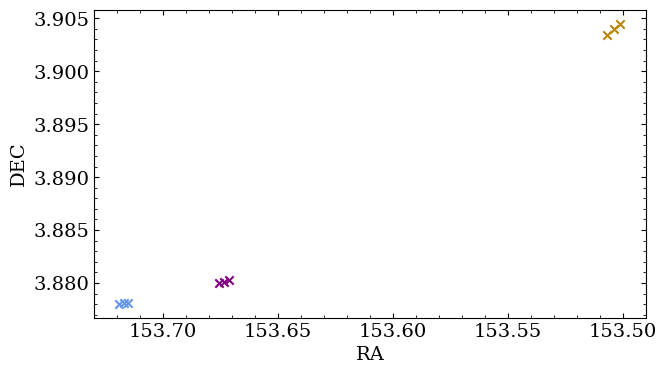

In [13]:
fig, ax = plt.subplots()
ax.scatter(coords.ra[:3], coords.dec[:3], c="cornflowerblue", marker="x")
ax.scatter(coords.ra[3:6], coords.dec[3:6], c="purple", marker="x")
ax.scatter(coords.ra[6:], coords.dec[6:], c="darkgoldenrod", marker="x")
ax.set_xlim(ax.get_xlim()[::-1])
ax.set(xlabel="RA", ylabel="DEC")

In [4]:
obs = Observations(
    observed_coordinates=coords,
    times=times,
    observatories="kitt peak",
    astrometric_uncertainties=1 * u.arcsec,
)
obs

Observations with 9 set(s) of observations

In [5]:
obj = Horizons(id="274301", location="500@0", epochs=times.tdb.jd[0])
vecs = obj.vectors(refplane="earth")
true_x0 = jnp.array([vecs["x"], vecs["y"], vecs["z"]]).T[0]
true_v0 = jnp.array([vecs["vx"], vecs["vy"], vecs["vz"]]).T[0]
true_x0, true_v0

(Array([-2.00572341,  1.77860129,  0.51974071], dtype=float64),
 Array([-0.00665991, -0.00662871, -0.00203885], dtype=float64))

In [6]:
p0 = Particle(
    x=true_x0, v=true_v0, time=times[0], name="274301 Wikipedia", observations=obs
)
p0.residuals(p0.cartesian_state)

Array([[-8.30998164e-07, -2.16312908e-07],
       [ 1.94550891e-06, -1.74741387e-06],
       [-1.34088575e-06,  1.33792739e-06],
       [-3.22417331e-07, -4.07570626e-09],
       [ 1.20954337e-06,  1.46488154e-06],
       [ 9.07413398e-07,  7.63774867e-07],
       [-8.09516725e-07, -1.04628034e-06],
       [-4.52546632e-07,  5.66870672e-07],
       [ 8.36123856e-07,  4.55996537e-08]], dtype=float64)

In [50]:
p0.keplerian_state

KeplerianState(semi=Array([2.37859645], dtype=float64), ecc=Array([0.14924503], dtype=float64), inc=Array([6.733637], dtype=float64), Omega=Array([183.37294715], dtype=float64), omega=Array([140.26386151], dtype=float64), nu=Array([173.65462561], dtype=float64), time=np.float64(2460676.792467407))

In [7]:
p1 = Particle(
    x=true_x0 + 1e-2, v=true_v0 - 1e-3, time=times[0], name="test particle", observations=obs
)
p1.residuals(p1.cartesian_state)

Array([[-1364.96108904,  1048.035659  ],
       [-1359.59781038,  1043.9035771 ],
       [-1354.23111574,  1039.76852767],
       [-1235.37790049,   948.24572831],
       [-1229.95184996,   944.06692865],
       [-1224.52240555,   939.88523587],
       [ -837.60554491,   642.21750478],
       [ -831.98869601,   637.89918004],
       [ -826.36858771,   633.57825018]], dtype=float64)

In [11]:
p_fit = p1.max_likelihood()
fit_resids = p_fit.residuals(p_fit.cartesian_state)
fit_resids

Array([[-1.73525640e-04, -7.19494170e-04],
       [-9.17755327e-05, -6.40024190e-04],
       [ 9.45047874e-06, -5.56428338e-04],
       [ 8.97450244e-06,  8.13916708e-04],
       [ 1.08145737e-04,  8.48159493e-04],
       [ 2.27776120e-04,  8.80254886e-04],
       [-5.77512078e-05, -1.50892526e-04],
       [-3.55438635e-05, -2.08396209e-04],
       [ 3.43443799e-06, -2.67256773e-04]], dtype=float64)

In [34]:
p_fit.keplerian_state

KeplerianState(semi=Array([2.37724559], dtype=float64), ecc=Array([0.14982436], dtype=float64), inc=Array([6.73733127], dtype=float64), Omega=Array([183.34436303], dtype=float64), omega=Array([139.77666834], dtype=float64), nu=Array([174.17188617], dtype=float64), time=np.float64(2460676.792467407))

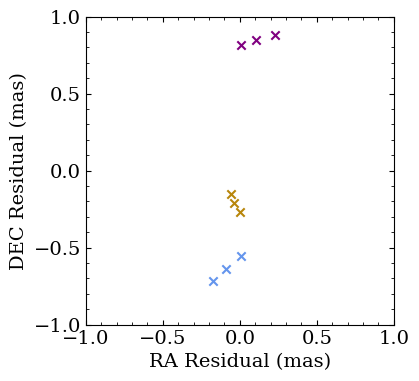

In [19]:
fig, ax = plt.subplots()
ax.scatter(fit_resids[:3, 0] * 1_000, fit_resids[:3, 1] * 1_000, c="cornflowerblue", marker="x")
ax.scatter(fit_resids[3:6, 0] * 1_000, fit_resids[3:6, 1] * 1_000, c="purple", marker="x")
ax.scatter(fit_resids[6:, 0] * 1_000, fit_resids[6:, 1] * 1_000, c="darkgoldenrod", marker="x")
ax.set(
    aspect="equal",
    xlim=(-1, 1),
    ylim=(-1, 1),
    xlabel="RA Residual (mas)",
    ylabel="DEC Residual (mas)",
);

In [35]:
ephem = p_fit.ephemeris(
    Time(np.linspace(times[0].utc.jd, times[-1].utc.jd, 500), format="jd", scale="utc"),
    observer="kitt peak",
)

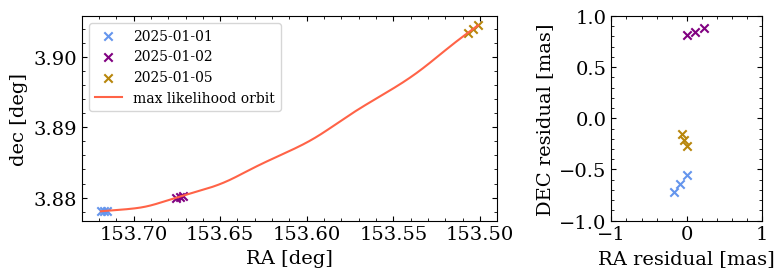

In [46]:
fig = plt.figure(figsize=(8, 3))
gs = fig.add_gridspec(1, 3)
ax1 = fig.add_subplot(gs[0, 0:2])
ax2 = fig.add_subplot(gs[0, 2])

ax1.scatter(coords.ra[:3], coords.dec[:3], c="cornflowerblue", marker="x", label="2025-01-01")
ax1.scatter(coords.ra[3:6], coords.dec[3:6], c="purple", marker="x", label="2025-01-02")
ax1.scatter(coords.ra[6:], coords.dec[6:], c="darkgoldenrod", marker="x", label="2025-01-05")
ax1.plot(ephem.ra, ephem.dec, c="tomato", label="max likelihood orbit")
ax1.set(xlabel="RA [deg]", ylabel="dec [deg]")
ax1.set_xlim(ax1.get_xlim()[::-1])
ax1.legend(fontsize="10")

ax2.scatter(fit_resids[:3, 0] * 1_000, fit_resids[:3, 1] * 1_000, c="cornflowerblue", marker="x")
ax2.scatter(fit_resids[3:6, 0] * 1_000, fit_resids[3:6, 1] * 1_000, c="purple", marker="x")
ax2.scatter(fit_resids[6:, 0] * 1_000, fit_resids[6:, 1] * 1_000, c="darkgoldenrod", marker="x")
ax2.set(
    xlim=(-1, 1),
    ylim=(-1, 1),
    xlabel="RA residual [mas]",
    ylabel="DEC residual [mas]",
)

plt.tight_layout()
plt.savefig("figures/max_likelihood_orbit.pdf")

In [49]:
from jorbit.astrometry.orbit_fit_seeds import gauss_method_orbit

p_fit.residuals(gauss_method_orbit(obs[::3]))

Array([[-10.61789004,   2.67988057],
       [-10.53195054,   2.63791056],
       [-10.4459514 ,   2.59592231],
       [ -8.54784698,   1.66684326],
       [ -8.46117802,   1.62437824],
       [ -8.37445603,   1.58189066],
       [ -2.24568889,  -1.43722726],
       [ -2.15735094,  -1.48094752],
       [ -2.06898726,  -1.52468309]], dtype=float64)

In [54]:
for i in p0.keplerian_state.items():
    print(f"{i[0]}: {1-p0.keplerian_state[i[0]] / p_fit.keplerian_state[i[0]]}")

semi: [-0.00056825]
ecc: [0.00386677]
inc: [0.00054833]
Omega: [-0.0001559]
omega: [-0.00348551]
nu: [0.00296983]
time: 0.0
